# Time Series Analysis in Medicine and Biology
## Practical Course 2026 – University of Tübingen

---
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/ShamsaraE/time-series-medicine-biology-2026/blob/main/notebooks/02_malaria_respiratory_deaths_structural_model.ipynb
)

---

# Case Study 2: Malaria (Kericho) – Multiplicative Time Series Modeling

This notebook explores multiplicative structure in malaria case data using `statsmodels`.

We include:
1. Classical additive decomposition on log scale
2. Classical multiplicative decomposition
3. STL decomposition
4. Log-linear regression using OLS

## 1. Load and prepare data

 If needed, data can alternatively be downloaded from:
https://sites.google.com/view/tsbiostat/home


CSV: `../data/kericho_data.csv` with columns `Year, Month, Cases, Rain, minT, maxT, VCAP`.

We convert `Year+Month` to a monthly datetime index and compute `log_cases`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/kericho_data.csv')

# Convert month names
month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
df['Month_num'] = df['Month'].map(month_map)

# Create datetime index
df['date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month_num'], day=1))
df = df.sort_values('date').set_index('date').asfreq('MS')

# Safe log transform
df['Cases_adj'] = df['Cases'].replace(0, 1)
df['log_cases'] = np.log(df['Cases_adj'])

df.head()

,Year,Month,Cases,Rain,minT,maxT,VCAP,Month_num,Cases_adj,log_cases
date,,,,,,,,,,
1979-01-01,1979,Jan,25,3.7,11.8,24.0,78.495712,1,25,3.218876
1979-02-01,1979,Feb,25,3.2,11.3,23.5,56.598073,2,25,3.218876
1979-03-01,1979,Mar,20,5.6,10.9,25.1,131.947726,3,20,2.995732
1979-04-01,1979,Apr,30,8.3,12.0,23.6,467.553308,4,30,3.401197
1979-05-01,1979,May,18,8.1,10.9,22.9,276.995422,5,18,2.890372


## 2. Raw vs Log Series

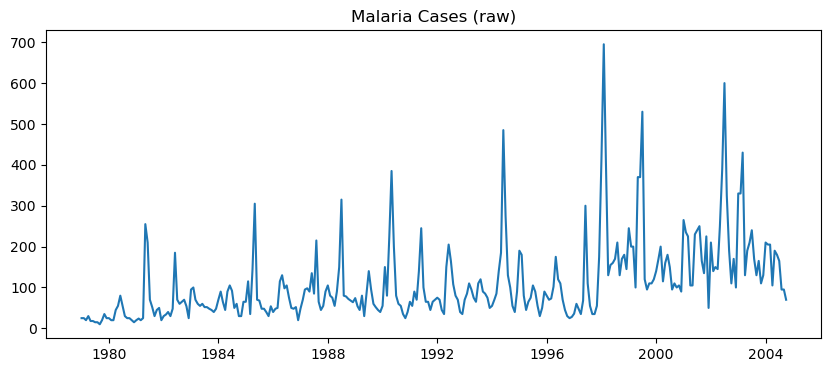

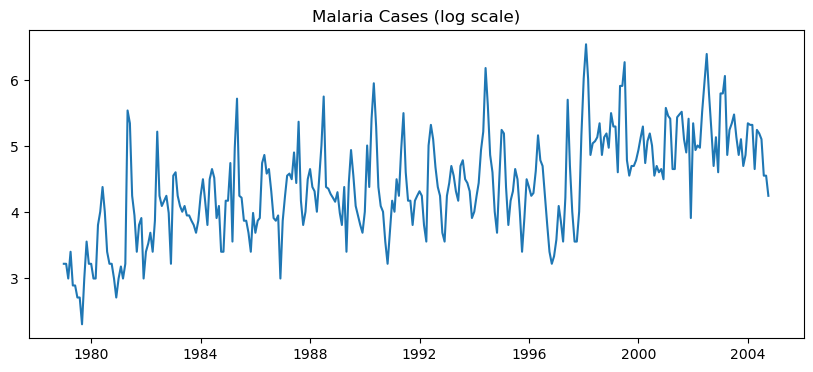

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df['Cases'])
plt.title('Malaria Cases (raw)')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df['log_cases'])
plt.title('Malaria Cases (log scale)')
plt.show()

## 3. Classical Additive Decomposition (on Log Scale)

Multiplicative structure becomes additive after log transform.

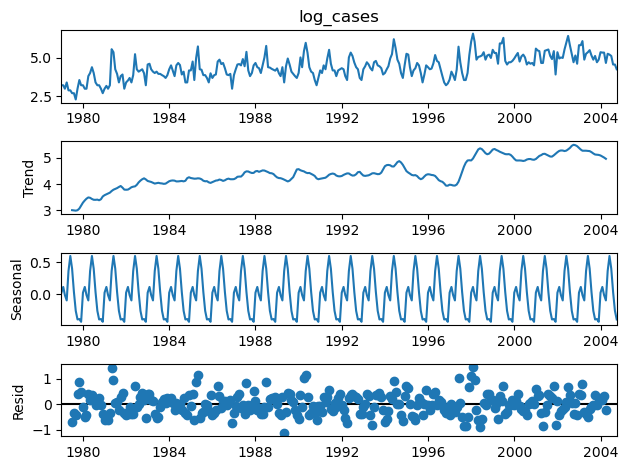

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df['log_cases'], model='additive', period=12)
result_add.plot()
plt.show()

## 4. Classical Multiplicative Decomposition (Original Scale)

This directly assumes:
$Y_t = Trend × Seasonal × Residual$

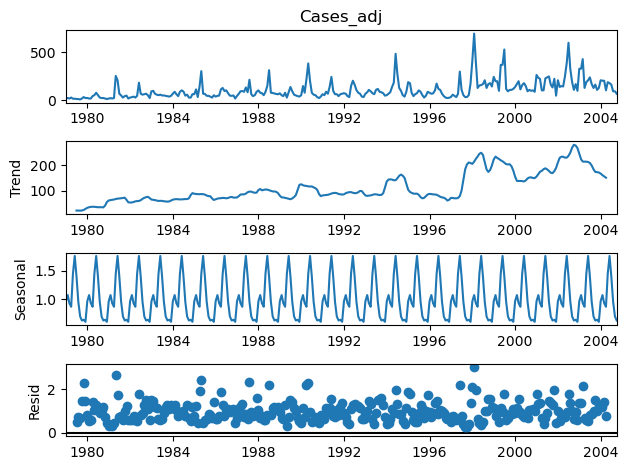

In [5]:
result_mult = seasonal_decompose(df['Cases_adj'], model='multiplicative', period=12)
result_mult.plot()
plt.show()

## 5. STL Decomposition (Flexible Seasonality)

STL allows seasonal patterns to evolve over time.

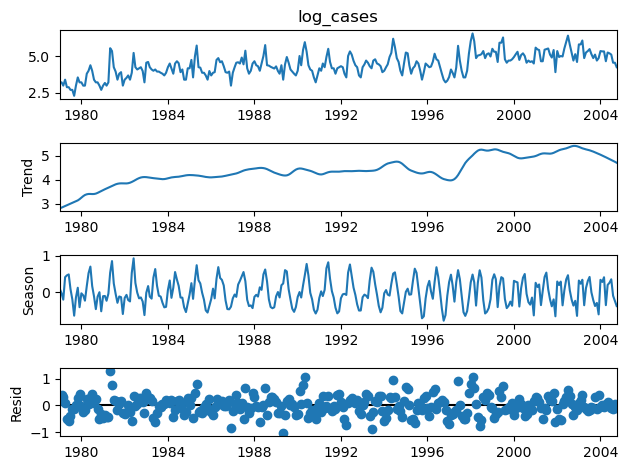

In [6]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['log_cases'], period=12)
res_stl = stl.fit()
res_stl.plot()
plt.show()

## 6. Log-Linear Regression using OLS

We fit:
$log(Y_t) = α + β t + ε_t$

In [7]:
import statsmodels.api as sm

t = np.arange(len(df))
X = sm.add_constant(t)
model = sm.OLS(df['log_cases'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_cases   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     203.0
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           9.80e-36
Time:                        10:41:32   Log-Likelihood:                -279.34
No. Observations:                 310   AIC:                             562.7
Df Residuals:                     308   BIC:                             570.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5722      0.068     52.739      0.0

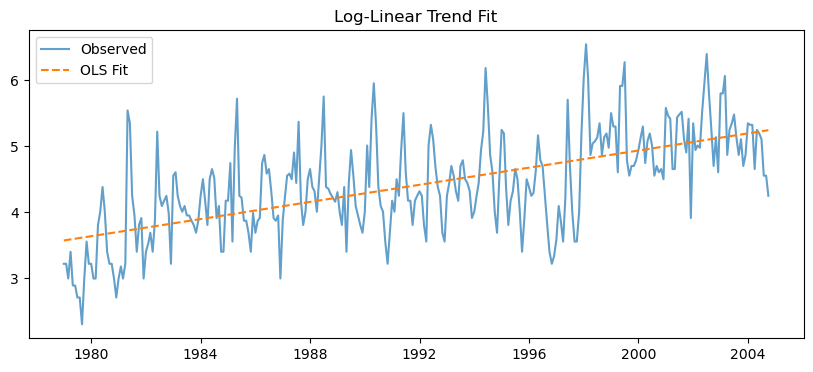

In [8]:
df['log_fit_ols'] = model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(df['log_cases'], label='Observed', alpha=0.7)
plt.plot(df['log_fit_ols'], label='OLS Fit', linestyle='--')
plt.legend()
plt.title('Log-Linear Trend Fit')
plt.show()